In [1]:
# TO BE RUN ONLY ONCE!
import os
os.chdir("../")

In [ ]:
## *******************************************************************************

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

import spatial_mix.hdp_utils as hdp_utils
from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

## Simulate data

<img src="simulation_scenario.png">

Simulate data as follows: for each little square we simulate data from a 3 components mixtures
$$ y_{ij} \sim w_{i1} N(-5, 1) + w_{i2} N(0, 1) + w_{i3} N(5, 1)$$

the weights depend on the location (x, y) of the center of the square (the orange dot)
$$ \widetilde{w}_{il} = \alpha_l x_i + \beta_l y_i \quad l=1, 2$$

finally $w_i = alr^{-1} ([\widetilde{w}_{i1}, \widetilde{w}_{i2}])$

In [ ]:
def inv_alr(x):
    out = np.exp(np.hstack((x, 1)))
    return out / np.sum(out)

In [ ]:
def simulate_from_mixture(weights):
    means = [-5, 0, 5]
    comp = np.random.choice(3, p=weights)
    return np.random.normal(loc=means[comp], scale=1)

In [ ]:
centers = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 0], [1, 0], [2, 0], [3, 0]])
centers = centers / 10
alpha1 = 0.3
alpha2 = -0.3
beta1 = 0.3
beta2 = -0.3

weights = []
for center in centers:
    w1 = alpha1 * center[0] + beta1 * center[1]
    w2 = alpha2 * center[0] + beta2 * center[1]
    weights.append(inv_alr([w1, w2]))

In [ ]:
Dmat1 = np.zeros((8, 8))

for i in range(7):
    Dmat1[i, i+1] = 1
    Dmat1[i+1, i] = 1
    if (i < 4):
        Dmat1[i, i+4] = 1
        Dmat1[i+4, i] = 1
    
print(Dmat1)

In [ ]:
np.savetxt("data/simulated_D1.csv", Dmat1, delimiter=",")

In [ ]:
data = []
for i in range(8):
    numSamples = 100
    if i == 5:
        numSamples = 20
        
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])

In [ ]:
df = pd.DataFrame(data, columns=["group", "data"])
df.to_csv("data/simulated_data1.csv", index=False)

# Simulated Scenario 2

In [ ]:
Dmat2 = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
]) 

print(Dmat2)

In [ ]:
w_group1 = np.array([0.25, 0.25, 0.5])
w_group2 = np.array([0.4, 0.4, 0.2])

weights = []

data = []
for i in range(8):
    w = w_group1 if i < 4 else w_group2
    weights.append(w)

In [ ]:
data = []
for i in range(8):
    numSamples = 1000
#     if i == 5:
#         numSamples = 20

    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])
        
# df = pd.DataFrame(data, columns=["group", "data"])
# df.to_csv("data/simulated_data2.csv", index=False)
# np.savetxt("data/simulated_D2.csv", Dmat2, delimiter=",")

# call C++ from terminal

In [ ]:
subprocess.call(
    "./spatial_mix/run_from_file.out"
    " data/simulated_data2.csv"
    " data/simulated_D2.csv"
    " data/chains_simulated2.recordio".split())

In [ ]:
print("./spatial_mix/run_from_file.out"
    " data/simulated_data2.csv"
    " data/simulated_D2.csv"
    " data/chains_simulated2.recordio")

## Run via the Python interface

In [ ]:
from spatial_mix.protos.py.sampler_params_pb2 import SamplerParams
from google.protobuf import text_format

df = pd.read_csv("data/simulated_data2.csv")
datas = []
for g in range(8):
    datas.append(df[df.group == g].data.values)

burnin = 10000
niter = 10000
thin = 10

chains = runSpatialMixtureSampler(burnin, niter, thin, Dmat2,
                                  "spatial_mix/resources/sampler_params.asciipb",
                                  datas, [])

## Plot density estimates

In [ ]:
# df = pd.read_csv("data/simulated_data2.csv")
# chains = loadChains("data/chains_simulated2.recordio")

In [ ]:
# datas = []
# for g in range(8):
#     datas.append(df[df.group == g].data.to_list())

In [ ]:
# chains 

In [ ]:
xgrid = np.linspace(-10, 10, 1000)
dens = estimateDensities(chains, xgrid)

In [ ]:
def post_hellinger_dist(estimatedDens, true, xgrid):
    return list(map(lambda x: hellinger_dist(x, true, xgrid), estimatedDens))

In [ ]:
g = 5
true_d = weights[g][0] * norm.pdf(xgrid, -5, 1.0) + \
         weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) + \
         weights[g][2] * norm.pdf(xgrid, 5.0, 1.0)

hell_dists = post_hellinger_dist(dens[g], true_d, xgrid)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.3])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[1])
    axes[g].set_title("Group: {0}".format(g))
#     sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [ ]:
estimateds = estimateDensities(chains, datas)
lpml(estimateds)

In [ ]:
chains[0].rho

In [ ]:
## Plot RhoChain
rhoChain = list(map(lambda x: x.rho, chains))
plt.plot(range(len(chains)), rhoChain)

In [ ]:
Wmat = Dmat2.astype(np.double)

## Hdp

In [3]:
subprocess.call(
    "./spatial_mix/run_hdp_from_file.out"
    " data/simulated_data2.csv"
    " data/chains_hdp_simulated2.recordio".split())

0

In [4]:
hdpChains = loadChains("data/chains_hdp_simulated2.recordio", HdpState)

In [13]:
def estimateDensity(cluster_sizes, betas, atoms, params, xgrid):
    out = np.zeros(len(xgrid))
    weights = np.zeros(len(atoms))
    ntot = sum(cluster_sizes)
    lam = params["priorLambda"]
    mu0 = params["priorMean"]
    a = params["priorA"]
    b = params["priorB"]
    for h in range(len(atoms)):
        weights[h] = cluster_sizes[h] + params["alpha"] * betas[h]

    weights /= (ntot + params["alpha"])

    for h, atom in enumerate(atoms):
        out += weights[h] * norm.pdf(xgrid, atom.mean, atom.stdev)

    bstar = xgrid ** 2 + lam * mu0 + \
        2 * b - (xgrid + (lam * mu0) ** 2 / (1 + lam))

    marg = 1 / (2 * np.pi) * b ** a * a * \
        np.sqrt(lam / (1 + lam)) / (bstar ** (a + 1))
    
    out += params["alpha"] * betas[-1] / (ntot + params["alpha"]) * marg
    return out


def estimateDensitiesHdp(chains, xgrids, nproc=-1):
    numGroups = len(chains[0].groupParams)
    if not isinstance(xgrids, list):
        xgrids = [xgrids] * numGroups
    numIters = len(chains)
    out = []
    for g in range(numGroups):
        curr = np.zeros((numIters, len(xgrids[g])))
        for i in range(numIters):
            params = {
                "alpha": chains[i].alpha,
                "priorMean": chains[i].hyper_params.mu0,
                "priorA": chains[i].hyper_params.a,
                "priorB": chains[i].hyper_params.b,
                "priorLambda": chains[i].hyper_params.lamb}
            curr[i, :] = estimateDensity(
                chains[i].groupParams[g].cluster_size, chains[i].betas,
                chains[i].atoms, params, xgrids[g])

        out.append(curr)
    return out

In [14]:
xgrid = np.linspace(-10, 10, 1000)
densHdp = estimateDensitiesHdp(hdpChains, xgrid)

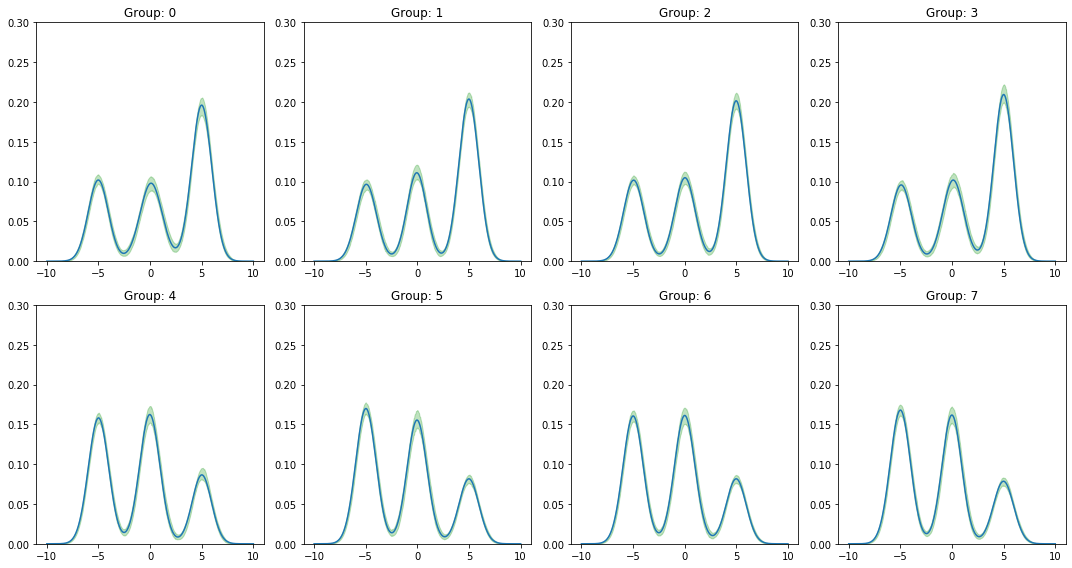

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
#     axes[g].plot(xgrid, 
#                  weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
#                  weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
#                  weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
#     obs = df[df["group"] == g]["data"].values
    # sns.kdeplot(obs, ax=axes[g])
    axes[g].set_ylim([0, 0.3])
    axes[g].plot(xgrid, np.mean(densHdp[g], 0))
    intervals = np.array([pm.stats.hpd(densHdp[g][:, i], 0.05) for i in range(densHdp[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
    
plt.tight_layout()